### All the details of these model and equations are mentioned in separate power point presentation .Here only codes are mentioned

##  Bonds Implementation

### Zero Coupon Bond

In [3]:
class ZeroCouponBond:

    def __init__(self, principal, maturity, interest_rate):
        # principal amount
        self.principal = principal
        # date to maturity
        self.maturity = maturity
        # market interest rate (discounting)
        self.interest_rate = interest_rate / 100

    def present_value(self, x, n):
        return x / (1+self.interest_rate)**n

    def calculate_price(self):
        return self.present_value(self.principal, self.maturity)


if __name__ == '__main__':

    bond = ZeroCouponBond(1000, 2, 4)
    print("Price of the bond in dollars: %.2f" % bond.calculate_price())


Price of the bond in dollars: 924.56


### Coupon Bond

In [4]:
class CouponBond:

    def __init__(self, principal, rate, maturity, interest_rate):
        self.principal = principal
        self.rate = rate / 100
        self.maturity = maturity
        self.interest_rate = interest_rate / 100

    def present_value(self, x, n):
        return x / (1+self.interest_rate)**n

    def calculate_price(self):

        price = 0

        # discount the coupon payments
        for t in range(1, self.maturity+1):
            price = price + self.present_value(self.principal * self.rate, t)

        # discount principle amount
        price = price + self.present_value(self.principal, self.maturity)

        return price


if __name__ == '__main__':

    bond = CouponBond(1000, 10, 3, 4)
    print("Bond price: %.2f" % bond.calculate_price())


Bond price: 1166.51


## Capital Asset Pricing Model(CAPM)

### Implementation

In [6]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Beta from formula:  0.7135101746895893
Beta from regression:  0.7135101746895895
Expected return:  0.09011314673574684


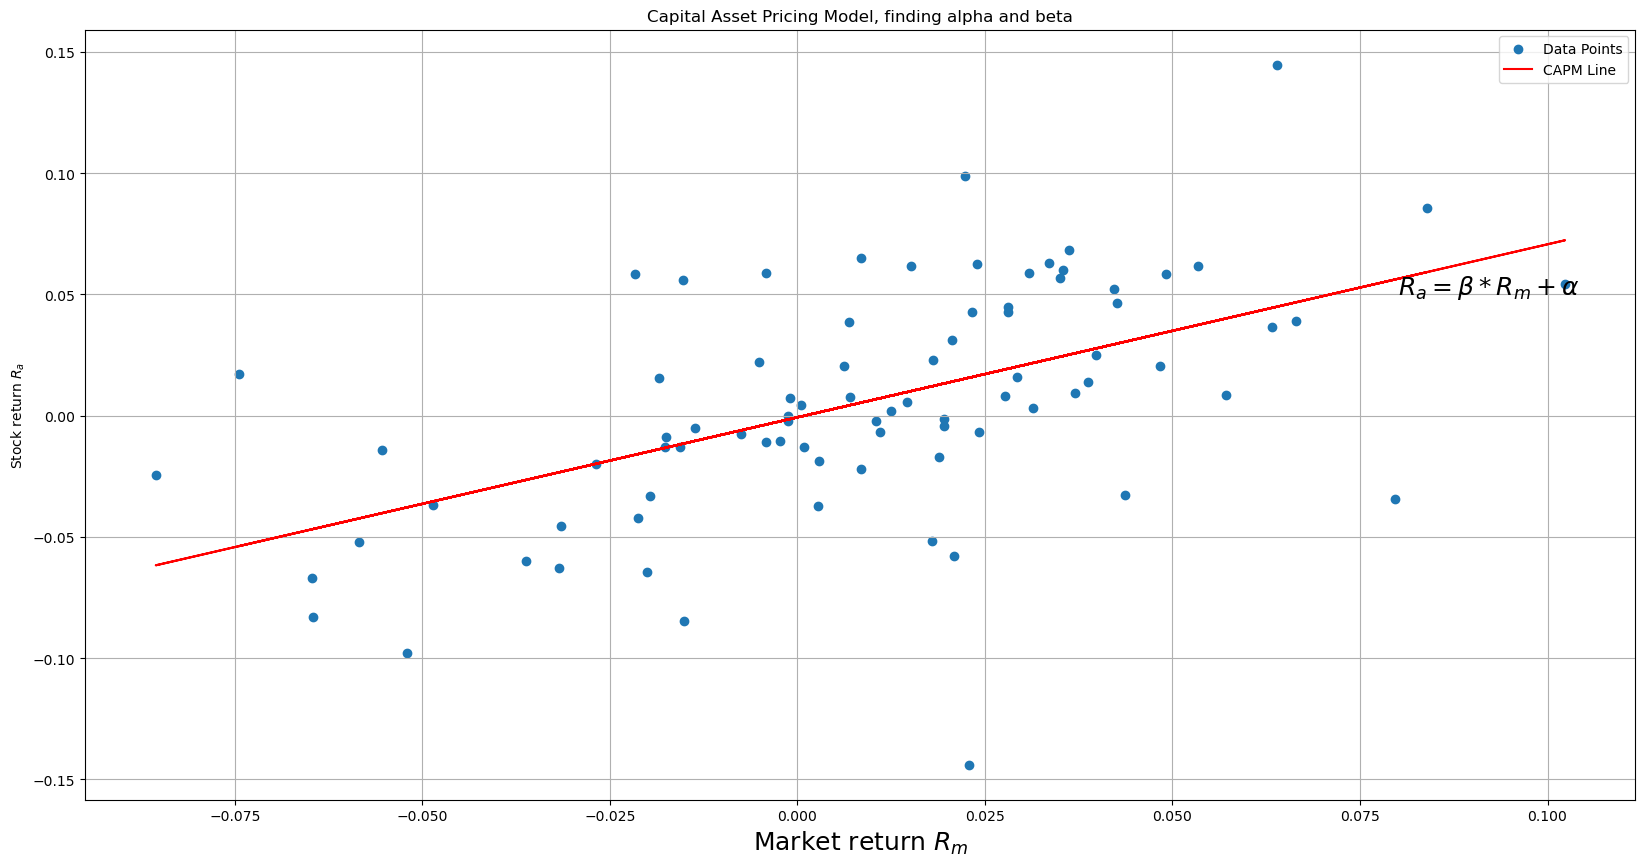

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# market interest rate
RISK_FREE_RATE = 0.05
# we will consider monthly returns - and we want to calculate the annual return
MONTHS_IN_YEAR = 12

class CAPM:

    def __init__(self, stocks, start_date, end_date):
        self.data = None
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date

    def download_data(self):
        data = {}

        for stock in self.stocks:
            ticker = yf.download(stock, self.start_date, self.end_date)
            data[stock] = ticker['Adj Close']

        return pd.DataFrame(data)

    def initialize(self):
        stock_data = self.download_data()
        # we use monthly returns instead of daily returns
        stock_data = stock_data.resample('M').last()

        self.data = pd.DataFrame({'s_adjclose': stock_data[self.stocks[0]],
                                  'm_adjclose': stock_data[self.stocks[1]]})

        # logarithmic monthly returns
        self.data[['s_returns', 'm_returns']] = np.log(self.data[['s_adjclose', 'm_adjclose']] /
                                                       self.data[['s_adjclose', 'm_adjclose']].shift(1))

        # remove the NaN values
        self.data = self.data[1:]

    def calculate_beta(self):
        # covariance matrix: the diagonal items are the variances
        # off diagonals are the covariances
        # the matrix is symmetric: cov[0,1] = cov[1,0] !!!
        covariance_matrix = np.cov(self.data["s_returns"], self.data["m_returns"])
        # calculating beta according to the formula
        beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
        print("Beta from formula: ", beta)

    def regression(self):
        # using linear regression to fit a line to the data
        # [stock_returns, market_returns] - slope is the beta
        beta, alpha = np.polyfit(self.data['m_returns'], self.data['s_returns'], deg=1)
        print("Beta from regression: ", beta)
        # calculate the expected return according to the CAPM formula
        # we are after annual return (this is why multiply by 12)
        expected_return = RISK_FREE_RATE + beta * (self.data['m_returns'].mean()*MONTHS_IN_YEAR
                                                   - RISK_FREE_RATE)
        print("Expected return: ", expected_return)
        self.plot_regression(alpha, beta)

    def plot_regression(self, alpha, beta):
        fig, axis = plt.subplots(1, figsize=(20, 10))
        axis.scatter(self.data["m_returns"], self.data['s_returns'],
                     label="Data Points")
        axis.plot(self.data["m_returns"], beta * self.data["m_returns"] + alpha,
                  color='red', label="CAPM Line")
        plt.title('Capital Asset Pricing Model, finding alpha and beta')
        plt.xlabel('Market return $R_m$', fontsize=18)
        plt.ylabel('Stock return $R_a$')
        plt.text(0.08, 0.05, r'$R_a = \beta * R_m + \alpha$', fontsize=18)
        plt.legend()
        plt.grid(True)
        plt.show()


if __name__ == '__main__':
    capm = CAPM(['IBM', '^GSPC'], '2010-01-01', '2017-01-01')
    capm.initialize()
    capm.calculate_beta()
    capm.regression()



## Markowitz Portfolio Model

### Implementation

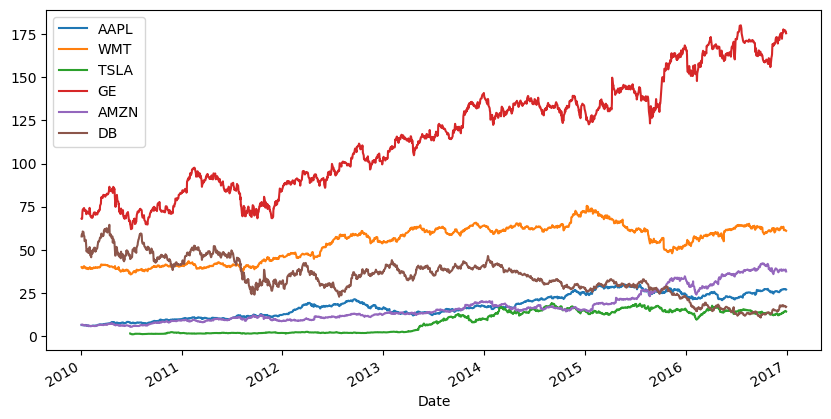

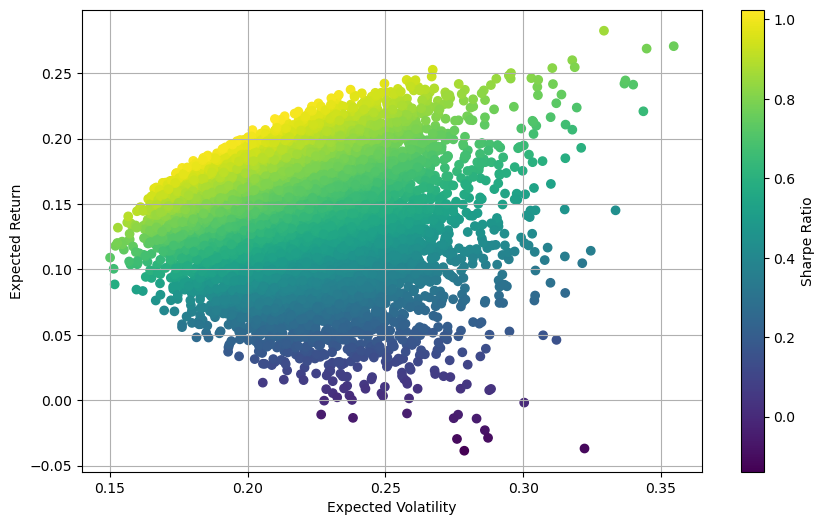

Optimal portfolio:  [0.363 0.077 0.141 0.155 0.264 0.   ]
Expected return, volatility and Sharpe ratio:  [0.21224731 0.20560875 1.03228739]


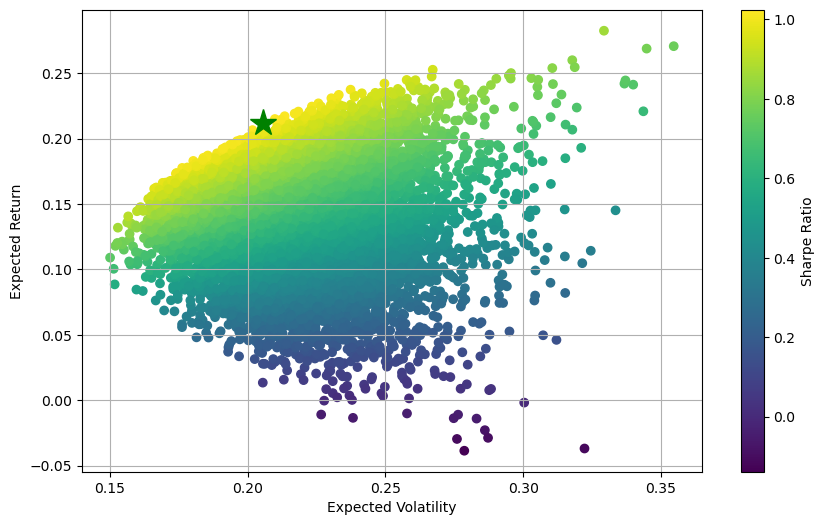

In [8]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

# on average there are 252 trading days in a year
NUM_TRADING_DAYS = 252
# we will generate random w (different portfolios)
NUM_PORTFOLIOS = 10000

# stocks we are going to handle
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']

# historical data - define START and END dates
start_date = '2010-01-01'
end_date = '2017-01-01'


def download_data():
    # name of the stock (key) - stock values (2010-1017) as the values
    stock_data = {}

    for stock in stocks:
        # closing prices
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']

    return pd.DataFrame(stock_data)


def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()


def calculate_return(data):
    # NORMALIZATION - to measure all variables in comparable metric
    log_return = np.log(data / data.shift(1))
    return log_return[1:]


def show_statistics(returns):
    # instead of daily metrics we are after annual metrics
    # mean of annual return
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)


def show_mean_variance(returns, weights):
    # we are after the annual return
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)


def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()


def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov()
                                                          * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)


def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility,
                     portfolio_return / portfolio_volatility])


# scipy optimize module can find the minimum of a given function
# the maximum of a f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]


# what are the constraints? The sum of weights = 1 !!!
# f(x)=0 this is the function to minimize
def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # the weights can be 1 at most: 1 when 100% of money is invested into a single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns
                                 , method='SLSQP', bounds=bounds, constraints=constraints)


def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ",
          statistics(optimum['x'].round(3), returns))


def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()


if __name__ == '__main__':
    dataset = download_data()
    show_data(dataset)
    log_daily_returns = calculate_return(dataset)
    # show_statistics(log_daily_returns)

    pweights, means, risks = generate_portfolios(log_daily_returns)
    show_portfolios(means, risks)
    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)


## Black-Scholes model

### Black-Scholes Model Implementation

In [10]:
from scipy import stats
from numpy import log, exp, sqrt


def call_option_price(S, E, T, rf, sigma):
    # first we have to calculate d1 and d2 parameters
    d1 = (log(S / E) + (rf + sigma * sigma / 2.0) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    print("The d1 and d2 parameters: %s, %s" % (d1, d2))
    # use the N(x) to calculate the price of the option
    return S*stats.norm.cdf(d1)-E*exp(-rf*T)*stats.norm.cdf(d2)


def put_option_price(S, E, T, rf, sigma):
    # first we have to calculate d1 and d2 parameters
    d1 = (log(S / E) + (rf + sigma * sigma / 2.0) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    print("The d1 and d2 parameters: %s, %s" % (d1, d2))
    # use the N(x) to calculate the price of the option
    return -S*stats.norm.cdf(-d1)+E*exp(-rf*T)*stats.norm.cdf(-d2)


if __name__ == '__main__':
    # underlying stock price at t=0
    S0 = 100
    # strike price
    E = 100
    # expiry 1year=365days
    T = 1
    # risk-free rate
    rf = 0.05
    # volatility of the underlying stock
    sigma = 0.2

    print("Call option price according to Black-Scholes model: ",
          call_option_price(S0, E, T, rf, sigma))
    print("Put option price according to Black-Scholes model: ",
          put_option_price(S0, E, T, rf, sigma))


The d1 and d2 parameters: 0.35000000000000003, 0.15000000000000002
Call option price according to Black-Scholes model:  10.450583572185565
The d1 and d2 parameters: 0.35000000000000003, 0.15000000000000002
Put option price according to Black-Scholes model:  5.573526022256971


### Predicting Stock Price with Monte-Carlo Simulation

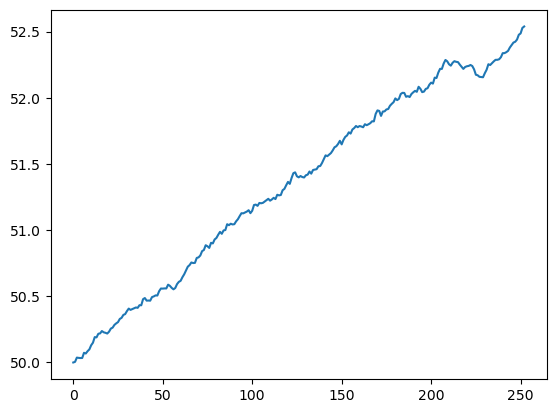

Prediction for future stock price: $52.54


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NUM_OF_SIMULATIONS = 1000


def stock_monte_carlo(S0, mu, sigma, N=252):

    result = []

    # number of simulations - possible S(t) realizations (of the process)
    for _ in range(NUM_OF_SIMULATIONS):
        prices = [S0]
        for _ in range(N):
            # we simulate the change day by day (t=1)
            stock_price = prices[-1] * np.exp((mu - 0.5 * sigma ** 2) +
                                              sigma * np.random.normal())
            prices.append(stock_price)

        result.append(prices)

    simulation_data = pd.DataFrame(result)
    # the given columns will contain the time series for a given simulation
    simulation_data = simulation_data.T

    simulation_data['mean'] = simulation_data.mean(axis=1)

    plt.plot(simulation_data['mean'])
    plt.show()

    print('Prediction for future stock price: $%.2f' % simulation_data['mean'].tail(1))


if __name__ == '__main__':
    stock_monte_carlo(50, 0.0002, 0.01)


### Black-Scholes model implementation with Monte-Carlo Simulation-2

In [13]:
import numpy as np


class OptionPricing:

    def __init__(self, S0, E, T, rf, sigma, iterations):
        self.S0 = S0
        self.E = E
        self.T = T
        self.rf = rf
        self.sigma = sigma
        self.iterations = iterations

    def call_option_simulation(self):
        # we have 2 columns: first with 0s the second column will store the payoff
        # we need the first column of 0s: payoff function is max(0,S-E) for call option
        option_data = np.zeros([self.iterations, 2])

        # dimensions: 1 dimensional array with as many items as the iterations
        rand = np.random.normal(0, 1, [1, self.iterations])

        # equation for the S(t) stock price at T
        stock_price = self.S0 * np.exp(self.T * (self.rf - 0.5 * self.sigma ** 2)
                                       + self.sigma * np.sqrt(self.T) * rand)

        # we need S-E because we have to calculate the max(S-E,0)
        option_data[:, 1] = stock_price - self.E

        # average for the Monte-Carlo simulation
        # max() returns the max(0,S-E) according to the formula
        # THIS IS THE AVERAGE VALUE !!!
        average = np.sum(np.amax(option_data, axis=1)) / float(self.iterations)

        # have to use the exp(-rT) discount factor
        return np.exp(-1.0*self.rf*self.T)*average

    def put_option_simulation(self):
        # we have 2 columns: first with 0s the second column will store the payoff
        # we need the first column of 0s: payoff function is max(0,S-E) for call option
        option_data = np.zeros([self.iterations, 2])

        # dimensions: 1 dimensional array with as many items as the iterations
        rand = np.random.normal(0, 1, [1, self.iterations])

        # equation for the S(t) stock price at T
        stock_price = self.S0 * np.exp(self.T * (self.rf - 0.5 * self.sigma ** 2)
                                       + self.sigma * np.sqrt(self.T) * rand)

        # we need S-E because we have to calculate the max(E-S,0)
        option_data[:, 1] = self.E - stock_price

        # average for the Monte-Carlo simulation
        # max() returns the max(0,S-E) according to the formula
        # THIS IS THE AVERAGE VALUE !!!
        average = np.sum(np.amax(option_data, axis=1)) / float(self.iterations)

        # have to use the exp(-rT) discount factor
        return np.exp(-1.0*self.rf*self.T)*average


if __name__ == '__main__':
    model = OptionPricing(100, 100, 1, 0.05, 0.2, 10000)
    print('Value of the call option is $%.2f' % model.call_option_simulation())
    print('Value of the put option is $%.2f' % model.put_option_simulation())




Value of the call option is $10.57
Value of the put option is $5.58


### Black-Scholes model implementation with Monte-Carlo Simulation-3

In [14]:
import numpy as np
import math
import time
 
class OptionPricing:
    
	def __init__(self,S0,E,T,rf,sigma,iterations):
		self.S0 = S0
		self.E = E
		self.T = T
		self.rf = rf
		self.sigma = sigma     
		self.iterations = iterations 
 
	def call_option_simulation(self):
		
		#we have 2 columns: first with 0s the second column will store the payoff
		#we need the first column of 0s: payoff function is max(0,S-E) for call option
		option_data = np.zeros([self.iterations, 2])
		
		#dimensions: 1 dimensional array with as many items as the itrations
		rand = np.random.normal(0, 1, [1, self.iterations])
		
		#equation for the S(t) stock price
		stock_price = self.S0*np.exp(self.T*(self.rf - 0.5*self.sigma**2)+self.sigma*np.sqrt(self.T)*rand)
 
		#we need S-E because we have to calculate the max(S-E,0)
		option_data[:,1] = stock_price - self.E   
        
		#average for the Monte-Carlo method
		#np.amax() returns the max(0,S-E) according to the formula
		average = np.sum(np.amax(option_data, axis=1))/float(self.iterations)
 
		#have to use the exp(-rT) discount factor
		return np.exp(-1.0*self.rf*self.T)*average
		
	def put_option_simulation(self):
	
		#we have 2 columns: first with 0s the second column will store the payoff
		#we need the first column of 0s: payoff function is max(0,E-S) for put option
		option_data = np.zeros([self.iterations, 2])
		
		#dimensions: 1 dimensional array with as many items as the itrations
		rand = np.random.normal(0, 1, [1, self.iterations])
		
		#equation for the S(t) stock price
		stock_price = self.S0*np.exp(self.T*(self.rf - 0.5*self.sigma**2)+self.sigma*np.sqrt(self.T)*rand)
 
		#we need E-S because we have to calculate the max(E-S,0)
		option_data[:,1] = self.E - stock_price  
        
		#average for the Monte-Carlo method
		#np.amax() returns the max(0,E-S) according to the formula
		average = np.sum(np.amax(option_data, axis=1))/float(self.iterations)
 
		#have to use the exp(-rT) discount factor
		return np.exp(-1.0*self.rf*self.T)*average

if __name__ == "__main__":
	
	S0=100					#underlying stock price at t=0
	E=100					#strike price
	T = 1					#expiry
	rf = 0.05				#risk-free rate
	sigma=0.2				#volatility of the underlying stock
	iterations = 1000000	#number of iterations in the Monte-Carlo simulation	
	
	model = OptionPricing(S0,E,T,rf,sigma,iterations)
	print("Call option price with Monte-Carlo approach: ", model.call_option_simulation()) 
	print("Put option price with Monte-Carlo approach: ", model.put_option_simulation())


Call option price with Monte-Carlo approach:  10.443343888027306
Put option price with Monte-Carlo approach:  5.577267838026761


## Value at Risk

### Implementation

In [15]:
import numpy as np
import yfinance as yf
from scipy.stats import norm
import pandas as pd
import datetime


def download_data(stock, start_date, end_date):
    data = {}
    ticker = yf.download(stock, start_date, end_date)
    data[stock] = ticker['Adj Close']
    return pd.DataFrame(data)


# this is how we calculate the VaR tomorrow (n=1)
def calculate_var(position, c, mu, sigma):
    var = position * (mu - sigma * norm.ppf(1-c))
    return var


# this is how we calculate the VaR for any days in the future
def calculate_var_n(position, c, mu, sigma, n):
    var = position * (mu * n - sigma * np.sqrt(n) * norm.ppf(1-c))
    return var


if __name__ == '__main__':

    start = datetime.datetime(2014, 1, 1)
    end = datetime.datetime(2018, 1, 1)

    stock_data = download_data('C', start, end)

    stock_data['returns'] = np.log(stock_data['C'] / stock_data['C'].shift(1))
    stock_data = stock_data[1:]
    print(stock_data)

    # this is the investment (stocks or whatever)
    S = 1e6
    # confidence level - this time it is 95%
    c = 0.99

    # we assume that daily returns are normally distributed
    mu = np.mean(stock_data['returns'])
    sigma = np.std(stock_data['returns'])

    print('Value at risk is: $%0.2f' % calculate_var_n(S, c, mu, sigma, 1))





[*********************100%***********************]  1 of 1 completed
                    C   returns
Date                           
2014-01-03  43.411251  0.021388
2014-01-06  43.744572  0.007649
2014-01-07  44.045361  0.006852
2014-01-08  44.557522  0.011561
2014-01-09  44.874561  0.007090
...               ...       ...
2017-12-22  63.072441 -0.004362
2017-12-26  62.479237 -0.009450
2017-12-27  62.571152  0.001470
2017-12-28  62.729900  0.002534
2017-12-29  62.170105 -0.008964

[1006 rows x 2 columns]
Value at risk is: $35762.33


### Implementation with Monte Carlo Simulation

In [16]:
import numpy as np
import yfinance as yf
import datetime
import pandas as pd


def download_data(stock, start, end):
    data = {}
    ticker = yf.download(stock, start, end)
    data['Adj Close'] = ticker['Adj Close']
    return pd.DataFrame(data)


class ValueAtRiskMonteCarlo:

    def __init__(self, S, mu, sigma, c, n, iterations):
        self.S = S
        self.mu = mu
        self.sigma = sigma
        self.c = c
        self.n = n
        self.iterations = iterations

    def simulation(self):
        stock_data = np.zeros([self.iterations, 1])
        rand = np.random.normal(0, 1, [1, self.iterations])

        # equation for the S(t) stock price
        stock_price = self.S * np.exp(self.n * (self.mu - 0.5 * self.sigma ** 2) + self.sigma * np.sqrt(self.n) * rand)

        # we have to sort the stock prices to determine the percentile
        stock_price = np.sort(stock_price)

        # it depends on the confidence level: 95% -> 5 and 99% -> 1
        percentile = np.percentile(stock_price, (1 - self.c) * 100)

        return self.S - percentile


if __name__ == "__main__":
    S = 1e6  # this is the investment (stocks or whatever)
    c = 0.95  # condifence level: this time it is 99%
    n = 1  # 1 day
    iterations = 100000  # number of paths in the Monte-Carlo simulation

    # historical data to approximate mean and standard deviation
    start_date = datetime.datetime(2014, 1, 1)
    end_date = datetime.datetime(2017, 10, 15)

    # download stock related data from Yahoo Finance
    citi = download_data('C', start_date, end_date)

    # we can use pct_change() to calculate daily returns
    citi['returns'] = citi['Adj Close'].pct_change()

    # we can assume daily returns to be normally sidtributed: mean and variance (standard deviation)
    # can describe the process
    mu = np.mean(citi['returns'])
    sigma = np.std(citi['returns'])

    model = ValueAtRiskMonteCarlo(S, mu, sigma, c, n, iterations)

    print('Value at risk with Monte-Carlo simulation: $%0.2f' % model.simulation())
	
	

[*********************100%***********************]  1 of 1 completed
Value at risk with Monte-Carlo simulation: $24878.97


## Interest Rate Modelling(Vasicek Model)

### Implementation

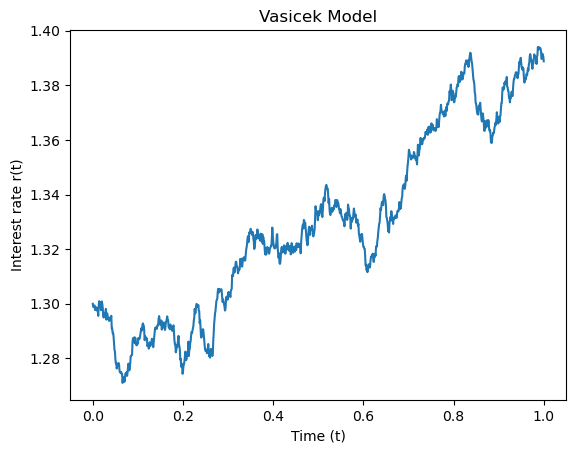

In [17]:
import matplotlib.pyplot as plt
import numpy as np


def vasicek_model(r0, kappa, theta, sigma, T=1., N=1000):

    dt = T/float(N)
    t = np.linspace(0, T, N+1)
    rates = [r0]

    for _ in range(N):
        dr = kappa*(theta-rates[-1])*dt + sigma*np.sqrt(dt)*np.random.normal()
        rates.append(rates[-1]+dr)

    return t, rates


def plot_model(t, r):
    plt.plot(t, r)
    plt.xlabel('Time (t)')
    plt.ylabel('Interest rate r(t)')
    plt.title('Vasicek Model')
    plt.show()


if __name__ == '__main__':

    time, data = vasicek_model(1.3, 0.9, 1.4, 0.05)
    plot_model(time, data)


### Pricing Bond with Vasicek Model

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# we will simulate 1000 r(t) interest rate processes
NUM_OF_SIMULATIONS = 1000
# these are the number of points in a single r(t) process
NUM_OF_POINTS = 200


def monte_carlo_simulation(x, r0, kappa, theta, sigma, T=1.):

    dt = T/float(NUM_OF_POINTS)
    result = []

    for _ in range(NUM_OF_SIMULATIONS):
        rates = [r0]
        for _ in range(NUM_OF_POINTS):
            dr = kappa * (theta - rates[-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
            rates.append(rates[-1] + dr)

        result.append(rates)

    simulation_data = pd.DataFrame(result)
    simulation_data = simulation_data.T

    # calculate the integral of the r(t) based on the simulated paths
    integral_sum = simulation_data.sum() * dt
    # present value of a future cash flow
    present_integral_sum = np.exp(-integral_sum)
    # mean because the integral is the average
    bond_price = x * np.mean(present_integral_sum)

    print('Bond price based on Monte-Carlo simulation: $%.2f' % bond_price)


if __name__ == '__main__':

    monte_carlo_simulation(1000, 0.1, 0.3, 0.3, 0.03)


Bond price based on Monte-Carlo simulation: $879.44
